In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pyproj 
from tqdm import tqdm
import reverse_geocoder as rg
from deap import base, creator, tools
import random
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from shapely.geometry import Point
from shapely.geometry import LineString

from preprocessing.pre_process_stations import *
from preprocessing.pre_process_traffic import *
from preprocessing.helping_functions import *

from features.config import *
from features.question_2_financials import *

from models.question_1 import *
from models.question_2 import *
from models.question_4 import *
from models.genetic_algorithm_part3_1 import *

import warnings
warnings.simplefilter('ignore')


def add_lat_lon_columns(df):
    """
    Adds new columns 'lonD', 'latD', 'lonF', 'latF' to the dataframe with
    corresponding latitude and longitude values based on the 'xD', 'yD', 'xF',
    and 'yF' columns, which are in Lambert-93 projection.
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the columns 'xD', 'yD', 'xF', and 'yF'.
    Returns:
    --------
    pandas.DataFrame
        The original dataframe with the new 'lonD', 'latD', 'lonF', and 'latF'
        columns added.
    """
    # Define the input and output projections
    in_proj = pyproj.Proj(init='epsg:2154')  # Lambert-93
    out_proj = pyproj.Proj(init='epsg:4326')  # WGS84

    df['xD'] = df['xD'].replace(',', '.')
    df['yD'] = df['yD'].replace(',', '.')
    df['xF'] = df['xF'].replace(',', '.')
    df['yF'] = df['yF'].replace(',', '.')

    # Convert start coordinates to lat-long
    df['lonD'], df['latD'] = pyproj.transform(in_proj, out_proj, df['xD'], df['yD'])

    # Convert end coordinates to lat-long
    df['lonF'], df['latF'] = pyproj.transform(in_proj, out_proj, df['xF'], df['yF'])

    return df

def read_shape_file(path: str):
    shp = gpd.read_file(path)
    return shp

def fix_tmja(df):
    # Fixing a few columns
    df.longueur = df.longueur.apply(lambda x: float(x.replace(',', '.')))
    df['ratio_PL'] = df['ratio_PL'].apply(lambda x: x if x<=40 else x/10)
    
    # Add lattitude and longitude
    df = add_lat_lon_columns(df)
    
    # Add region and department with lattitude and longitude
    coordinates = [(i[1], i[0]) for i in shp_tmja[['lonD', 'latD']].values]
    results = rg.search(coordinates)
    df['region'] = [i['admin1'] for i in results]
    df['departement'] = [i['admin2']\
                         .replace('Departement de ', '')\
                         .replace('Departement du ', '')\
                         .replace('Departement des ', '')\
                         .replace("Departement d'", '')\
                         .replace('la ', '')\
                         .replace("l'", "") for i in results]
    
    return df

def fix_stations(df):
    df['Coordinates'] = df['Coordinates'].apply(lambda x: x.replace(',,', ','))
    return df

def indicate_crs(shp_file: gpd.geodataframe.GeoDataFrame, epsg:str):
    shp_file.set_crs(epsg, allow_override=True)
    return shp_file

def convert_long_lat_to_easting_northing(df, initial_epsg='epsg:4326', target_epsg='epsg:2154'):
    # Define the input and output projections
    in_proj = pyproj.Proj(init='epsg:4326')  # Lambert-93
    out_proj = pyproj.Proj(init='epsg:2154')  # WGS84

    long = df['Coordinates'].apply(lambda x: x.split(',')[1]).values.astype(float)
    lat = df['Coordinates'].apply(lambda x: x.split(',')[0]).values.astype(float)

    # Convert start coordinates to lat-long
    long_transformed, lat_transformed = pyproj.transform(in_proj, out_proj, long, lat)
    
    df.geometry = gpd.points_from_xy(x=long_transformed, 
                                     y=lat_transformed, crs='epsg:2154')
    
    return df

def convert_str_geometry_to_geometry_geometry(df):
    df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry'])
    return df

def new_coordinates_creation(approximate_nb_of_points, shapefile_tmja: gpd.geodataframe.GeoDataFrame):
    total_distance = shapefile_tmja.geometry.length.sum() # in meters
    distance_between_coordinates = total_distance/approximate_nb_of_points
    points = []
    routes = []

    for idx in tqdm(shapefile_tmja.index):
        line = shapefile_tmja.geometry[idx]
        route = shapefile_tmja.route[idx]
        n_splits = int(line.length/distance_between_coordinates)
        
        if n_splits < 2:
            splitter = [line.interpolate((i/2), normalized=True) for i in range(2)]
        else:
            splitter = [line.interpolate((i/n_splits), normalized=True) for i in range(n_splits)]

        points.append(splitter)
        routes.append([route for i in (range(n_splits) if n_splits >= 2 else range(2))])
        
    routes = np.concatenate(routes)
    
    coordinates = pd.DataFrame([i.wkt.replace('POINT (', '').replace(')', '').split(' ') for i in np.concatenate(points)])
    coordinates.columns = ["easting", "northing"]
    coordinates['route'] = routes
    coordinates['geometry'] = gpd.points_from_xy(x=coordinates.easting, 
                                                 y=coordinates.northing,
                                                 crs=shp_tmja.crs)
    
    shp_coordinates = gpd.GeoDataFrame(coordinates)
    
    return shp_coordinates

def compute_distance_to_closest_large_hub(df_stations:gpd.geodataframe.GeoDataFrame, df_hub_elargies:gpd.geodataframe.GeoDataFrame):
    large_hub_list = []
    distance_to_large_hub_list = []

    for idx_station in tqdm(df_stations.index):
        geodf = gpd.GeoDataFrame(df_stations.iloc[idx_station].geometry.distance(df_hub_elargies.geometry))
        min_distance = df_stations.iloc[idx_station].geometry.distance(df_hub_elargies.geometry).min()
        idx_hub = geodf[geodf['geometry'] == min_distance].index[0]
        # print(stations.loc[idx_station, 'nom'], roads.loc[idx_road, 'nom'], min_distance)
        large_hub_list.append(df_hub_elargies.at[idx_hub, 'e1'])
        distance_to_large_hub_list.append(min_distance)


    df_stations['closest_large_hub'] = large_hub_list
    df_stations['distance_to_closest_large_hub'] = distance_to_large_hub_list
    
    return df_stations


def compute_distance_to_closest_dense_hub(df_stations:gpd.geodataframe.GeoDataFrame, df_hub_denses:gpd.geodataframe.GeoDataFrame):
    dense_hub_list = []
    distance_to_dense_hub_list = []

    for idx_station in tqdm(df_stations.index):
        geodf = gpd.GeoDataFrame(df_stations.iloc[idx_station].geometry.distance(df_hub_denses.geometry))
        min_distance = df_stations.iloc[idx_station].geometry.distance(df_hub_denses.geometry).min()
        idx_hub = geodf[geodf['geometry'] == min_distance].index[0]
        # print(stations.loc[idx_station, 'nom'], roads.loc[idx_road, 'nom'], min_distance)
        dense_hub_list.append(df_hub_denses.at[idx_hub, 'e1'])
        distance_to_dense_hub_list.append(min_distance)

    df_stations['closest_dense_hub'] = dense_hub_list
    df_stations['distance_to_closest_dense_hub'] = distance_to_dense_hub_list

    return df_stations

def compute_distance_to_each_station(df):
    for i in tqdm(df.index):
        URL = df.loc[i, 'URL']
        df[f'distance_to_{URL}'] = df.loc[i, 'geometry'].distance(df.geometry)
    return df



In [2]:
shp_tmja = read_shape_file("../../data/E-tmja2019-shp-improved")

In [3]:
results = pd.read_csv('../../data/results_ga_2.csv', index_col='index').drop('Unnamed: 0', axis=1)

In [4]:
def plot_results(roads_shapefile:gpd.geodataframe.GeoDataFrame, df_results:pd.core.frame.DataFrame):
    """
    Plot the results of a simulation of H2 station placement on a map.

    Parameters:
    roads_shapefile : GeoDataFrame
    A GeoDataFrame containing the roads' shapefile data.

    df_results : DataFrame
    A DataFrame containing the H2 station placement simulation results.
    It should contain a 'geometry' column containing the stations' location in
    string or Shapely.geometry format, and a 'station_type' column with the
    type of station (i.e., small, medium, large).

    Returns:
    A plot of the roads and H2 stations overlaid on a map.

    """
    roads = gpd.GeoDataFrame({'geometry': roads_shapefile.geometry, 
                              'type': ['route' for i in range(len(roads_shapefile.geometry))],
                              'nom': roads_shapefile.route}, 
                             crs=roads_shapefile.crs)
    
    if type(df_results.geometry[:1].values[0]) == str:
        df_results = convert_str_geometry_to_geometry_geometry(results)
        
    stations = gpd.GeoDataFrame({'geometry': df_results.geometry, 
                                 'type': [f'{i} H2 station' for i in df_results["station_type"]],
                                 'nom': [f'H2 station n{i}' for i in range(df_results.shape[0])]}, 
                                crs=roads_shapefile.crs)
    
    shp_file = pd.concat([roads, stations])
    exploration = shp_file.explore(column='type', cmap='tab10')
    
    return exploration
    

In [6]:
scenario_example = pd.read_csv('../../data/sceanrio_example.csv', index_col="Unnamed: 0")

In [11]:
def plotting_installations(df:pd.core.frame.DataFrame):
    """
    Plot the installation dates of H2 stations on a map.

    Parameters:
        df : DataFrame
            A DataFrame containing data on H2 stations' installation, including their
            location and installation date.

    Returns:
        A plot of the H2 station locations overlaid on a map, with the color of each
            station indicating its installation date.

    """

    if type(df.geometry[:1].values[0]) == str:
        df = convert_str_geometry_to_geometry_geometry(df)
        
    shp_file = gpd.GeoDataFrame(df, crs="epsg:2154")
    shp_file = shp_file[['URL', 'nom_region', 'geometry', 'closest_road',
       'closest_large_hub', 'closest_dense_hub', 'TMJA_PL', 'percentage_traffic',
       'Quantity_sold_per_day(in kg)', 'Revenues', 'bool', 'size',
       'Quantity_sold_per_year(in kg)', 'station_type', 'Revenues_day',
       'EBITDA', 'Opex', 'EBIT', 'depreciation', 'date_installation']]
    
    exploration = shp_file.explore(column="date_installation", cmap="Blues")
    
    return exploration

In [190]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
%matplotlib inline

In [216]:
def clustering_of_stations(results:pd.core.frame.DataFrame, k_max:int=40):
    results_to_cluster = results[['easting', "northing"]]
    result_of_clustering = {}
    K = range(2, k_max)
    for k in tqdm(K):
        result_of_clustering[k] = {}
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(results_to_cluster)
        result_of_clustering[k]['inertia'] = kmeanModel.inertia_
        result_of_clustering[k]['silhouette'] = silhouette_score(results_to_cluster, kmeanModel.labels_)
        result_of_clustering[k]['labels'] = kmeanModel.labels_
        result_of_clustering[k]['centroids'] = kmeanModel.cluster_centers_
    
    _, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,16))

    ax1.plot(K, [i["inertia"] for i in result_of_clustering.values()], 'bx-')

    ax2.plot(K, [i["silhouette"] for i in result_of_clustering.values()], 'bx-')

    ax1.set_title('Finding the optimal k', {'fontsize':30})
    ax1.set_ylabel('Inertia')
    ax2.set_ylabel('Silhouette score')

    plt.show()

    return result_of_clustering 

100%|███████████████████████████████████████████| 38/38 [00:03<00:00,  9.54it/s]


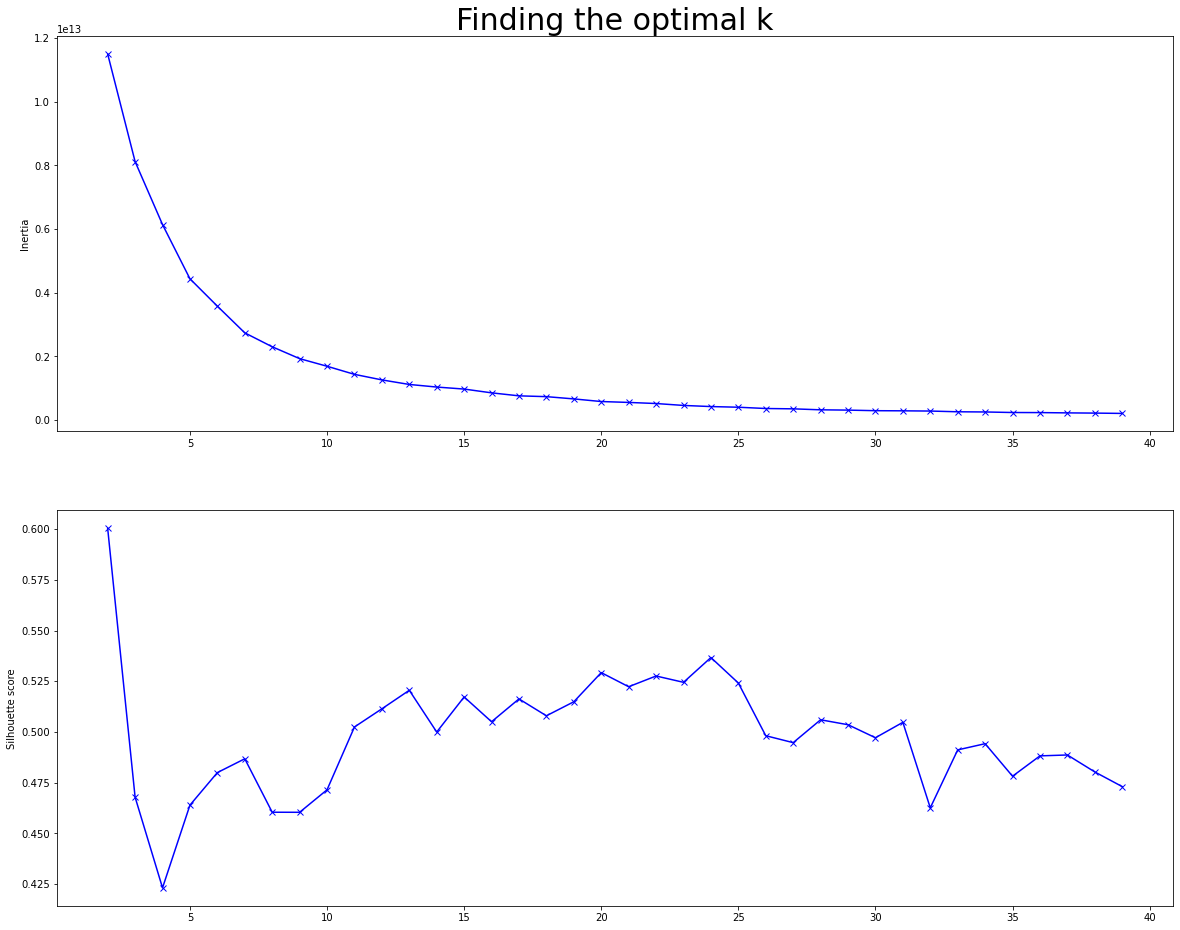

In [217]:
result_of_clustering_test_function = clustering_of_stations(results)

In [94]:
results_to_cluster['cluster'] = result_of_clustering[21]['labels']

In [95]:
results_to_cluster['geometry'] = results.geometry

In [120]:
clustered_results = gpd.GeoDataFrame(results_to_cluster, crs="epsg:2154")#.explore(column="cluster", cmap="hsv")

In [483]:
def plot_clusters_(productions_sites, routes, stations, cmap="gist_ncar"):
    shp_production_sites = gpd.GeoDataFrame({'geometry': production_sites.geometry, 
                                         'nom': [f'{i+1}th production site' for i in range(production_sites.shape[0])]}, 
                                        crs="epsg:2154")
    
    shp_routes = gpd.GeoDataFrame({'geometry': routes.geometry, 
                                         'nom': ['0 route' for i in range(routes.shape[0])]}, 
                                        crs="epsg:2154")
    
    shp_file = pd.concat([shp_routes, shp_production_sites])

    mask = shp_file['nom'] != "0 route"
    shp_file.loc[mask, 'geometry'] = shp_file.loc[mask, 'geometry'].apply(lambda x: x.buffer(50000))


    shp_stations = gpd.GeoDataFrame({'geometry': stations.geometry, 
                                         'nom': [f'{i+1}th cluster of stations' for i in stations.cluster]}, 
                                        crs="epsg:2154")
    
    shp_file = pd.concat([shp_file, shp_stations])
    
    exploration = shp_file.explore(column='nom', cmap=cmap)
    
    return exploration